In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle

In [69]:
FIBER = 'Draka_GRIN'
DATA_PATH = Path("../Data") / FIBER
# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    return os.path.join(DATA_PATH, file_name)


def image_path(file_name):
    return os.path.join(IMAGE_FOLDER, file_name)


In [70]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
FIGSIZE = (8, 5)
SAVE_FIG = True

# I. Load data

## A. Load parameters

### A.1 Load data from files

In [71]:
DATA_FILE = DATA_PATH / "processed_data_001_c.pkl"
qs = (0, 1, 2, 3)
deformations2show = [0,2,3,4]

#load pickle
with open(DATA_FILE, 'rb') as f:
    data = pickle.load(f)

In [72]:
# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# deformation values
Delta_x = param["Delta_x"]

### A.2 Fiber parameters

In [ ]:
## Physical parameters
L_tot = data["theo"]["L_tot"]
radius = data["theo"]["radius"]
d_layer = data["theo"]["d_layer"]
dz = data["theo"]["dz"]
k0 = 2.0 * np.pi / wl
# difference of refractive index between the axis (maximum value) and the cladding (minimum value)
Dn = NA**2 / (2.0 * n1)

## Mode parameters
nmodes = data["modes"]["nmodes"]
betas = data["modes"]["betas"]
M = data["theo"]["M_norm"] # mode matrix
m = data["modes"]["m"]
deltaM = data["modes"]["deltaM"]
l = data["modes"]["l"]
deltaBeta = data["modes"]["deltaBeta"]





### A.3 Theory parameters

In [84]:
# number of segments to consider
Nz = data['theo']['Nz']
Nz = L_tot / dz

# range and discretization parameters for the numerical estimation
# of the terms of Eq.X
dr = data["theo"]["dr"]
r_max = data["theo"]["r_max"]

KeyError: 'Nz'

## B. Load results

### B.1 Load numerical and experimental correlation results

In [ ]:
Corr_seg_mean = data["simu"]["Corr_mean"]
Corr_seg_std = data["simu"]["Corr_std"]
# Corr_theory_0 = data["theo"]["Corr_mean"]
Corr_mean_exp = data["exp"]["Corr_mean"]
Corr_std_exp = data["exp"]["Corr_std"]

### B.2 Load theory fit parameters

In [ ]:
# fitted values for the deformation parameters ($\Gamma_q$ in the paper)
gammas = data['theo']['gammas']
# angles values for the angular correlation (same as in experiment)
angles = data["exp"]["angles"]
# q values to consider in the azimuthal series decomposition
qs = data['theo']['qs']

# II. Recompute correlation using theoretical predictions

In [74]:
with open(file_path("param.pkl"), "rb") as file:
    param_big = pickle.load(file, encoding="latin1")

In [75]:
param_big["fiber"].keys()

dict_keys(['NA', 'radius', 'name', 'type', 'wl', 'n1', 'curvature', 'length', 'ipitch', 'opitch', 'inpoints', 'onpoints'])

In [78]:
sinc = lambda x: np.sinc(x / np.pi)

r_vec = np.arange(0, r_max, dr)


noise_std = lambda r: -2 * r / (radius**2) * Dn * d_layer * (r > 0) * (r < radius)

MsqR = M**2 * r_vec * noise_std(r_vec)
I = MsqR @ MsqR.transpose() * d_layer * dr  
# beta dependence
mask_beta = sinc(deltaBeta / 2 * dz) ** 2

# coefficient A
coeff = L_tot / dz * (k0 * dz) ** 2 * 1 / nmodes * 0.25


In [79]:


def Compute_correlation(gammas, qs):
    C1 = None
    for q, gamma in zip(qs, gammas):
        mask_M = np.abs(deltaM) == q
        A = np.sum(mask_beta * mask_M * I) or 0.0
        # cq = gamma**2 * np.cos(q * angles) * A
        cq = gamma**2 * (np.cos(q * angles)-1) * A
        C1 = cq if C1 is None else C1 + cq

    C = 1 + coeff * C1
    # C = C / C[0]

    return C

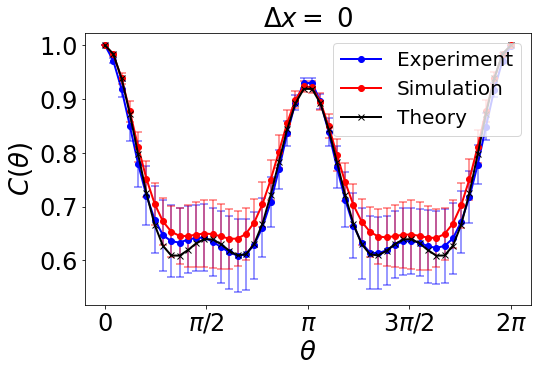

In [80]:
Corr_theory = np.stack(
    [Compute_correlation(g, qs) for g in gammas], axis=0
)
show_RME_corr(show_error=True, ind_deformation=0, save_fig=True)

In [81]:
gammas.shape

(5, 4)

# Display results

KeyError: 'simu'

In [ ]:
deformation_indices = param["deformation_indices"]

IndexError: index 1 is out of bounds for axis 0 with size 1

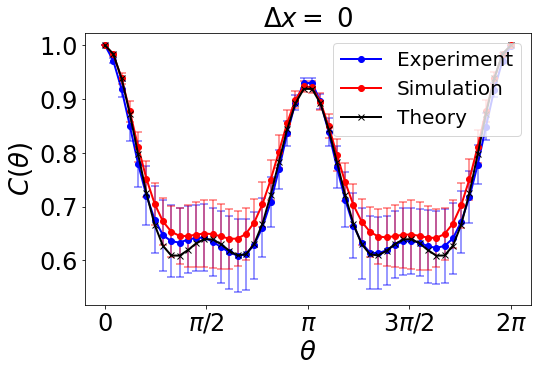

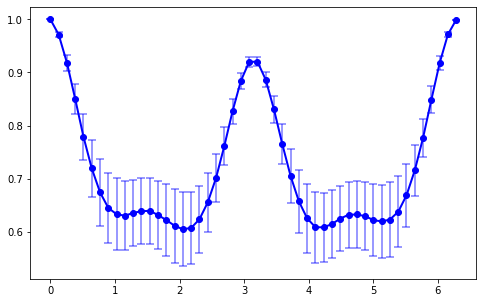

In [ ]:
def plot_error(y, y_err, color):
    plt.errorbar(
        angles,
        y,
        yerr=y_err,
        color=color,
        linewidth=2,
        linestyle="None",
        capsize=4,
        capthick=2,
        alpha=0.4,
    )
    
def show_RME_corr(show_error=True, ind_deformation=0, save_fig=True):
    # deformations2show = [0,2,3,4]
    plt.figure(figsize=FIGSIZE)

    for ind_deformation in [ind_deformation]:
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"Experiment",
            color="blue",
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color="blue",
            )

    plt.errorbar(
        angles,
        Corr_seg_mean[ind_deformation],
        label=rf"Simulation",
        color="red",
        marker="o",
        linewidth=2,
    )

    if show_error:
        plot_error(
            Corr_seg_mean[ind_deformation], Corr_seg_std[ind_deformation], color="red"
        )

    plt.errorbar(
        angles,
        Corr_theory[ind_deformation],
        label=rf"Theory",
        color="black",
        marker="x",
        linewidth=2,
    )

    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    # plt.ylim([0.3, 1.05])
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc="upper right")
    plt.title(rf"$\Delta x =$ {Delta_x[ind_deformation]:.0f}", fontsize=TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RME_exp_Vs_simu_Dx_{Delta_x[ind_deformation]:.0f}.svg"),
            dpi=300,
        )


for ind_deformation in range(len(deformation_indices)):
    show_RME_corr(show_error=True, ind_deformation=ind_deformation, save_fig=True)

## B. $\Gamma_q$ as a function of the deformation

The values of $\Gamma_q$ are found by fitting the theoretical prediction 
(Eq.4 of the main text) 
to the experimental data.
They represent the azimuthal perturbation of the refractive index $\sum_q \Gamma_q\cos(q\phi)$



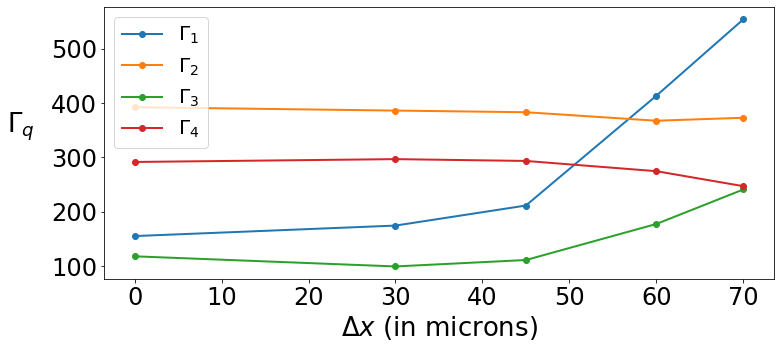

In [83]:
gammas = data['theo']['gammas']

plt.figure(figsize = (12,5))
for ind_q, q in enumerate(qs):
    plt.plot(
        Delta_x, 
        gammas[:,ind_q], 
        marker = 'o',
        label = rf'$\Gamma_{q}$',
        linewidth = 2,
    )
plt.legend()
plt.ylabel(r'$\Gamma_q$', fontsize=LABEL_SIZE, labelpad=30, rotation=0)
plt.xlabel(r"$\Delta x$ (in microns)", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc = 'upper left')
# plt.ylim([0.,0.9])

if SAVE_FIG:
    plt.savefig(
        image_path(f"Gamma_q.svg"),
        dpi=300,
    )
